In [2]:
import ROOT
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch.nn as nn
import torchvision
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.optimize import curve_fit
torch.manual_seed(114514)

Welcome to JupyROOT 6.26/04


In [3]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [4]:
#construct the model
class custom1(nn.Module):
    def __init__(self, in_dim) -> None:
        super().__init__()
        self.input = nn.Linear(in_dim, 100)
        self.layer0 = nn.Linear(100, 75)
        self.layer1 = nn.Linear(75,75)
        self.layer2 = nn.Linear(75,50)
        self.output = nn.Linear(50, 1)

    def forward(self, x):
        x = nn.ReLU()(self.input(x))
        x = nn.Tanh()(self.layer0(x))
        x = nn.ReLU()(self.layer1(x))
        x = nn.ReLU()(self.layer2(x))
        output = nn.Sigmoid()(self.output(x))
        return output


In [5]:
#loading dataset for training
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.RandomHorizontalFlip]
)

b_jet = (pd.read_csv("/global/cscratch1/sd/ricardom/b_jet.csv")).to_numpy()
c_jet = (pd.read_csv("/global/cscratch1/sd/ricardom/c_jet.csv")).to_numpy()
data_X = np.concatenate((b_jet, c_jet)) #data
#creating label for c_jet and b_jet: c -> 1, b -> 0
b_label = np.zeros((b_jet.shape[0]))
c_label = np.ones((c_jet.shape[0]))
data_y = np.concatenate((b_label, c_label)) #label for data

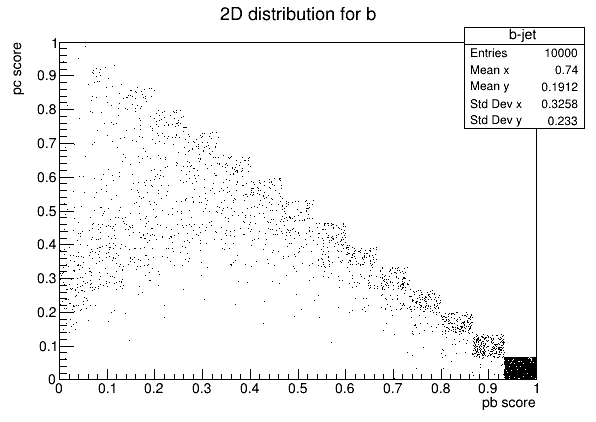

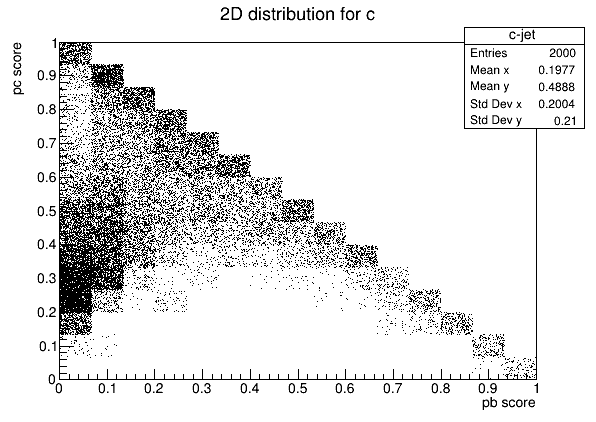

In [6]:
#plot 2d distribution for each jet with 1e4 scales of sample
num = int(1e4)
b = ROOT.TCanvas("b-jet {}".format(num),"The Canvas Title",600,450)
b_2D = ROOT.TH2F("b-jet", "2D distribution for b", 15, 0, 1, 15, 0, 1)
b_2D.FillN(num, b_jet[:, 0], b_jet[:, 1], 1/num*np.ones(num))
b_2D.Draw()
b.cd()
b_2D.GetYaxis().SetTitle("pc score")
b_2D.GetXaxis().SetTitle("pb score")
b.Draw()


num = int((1e4)/5)
c = ROOT.TCanvas("c-jet {}".format(num),"The Canvas Title",600,450)
c_2D = ROOT.TH2F("c-jet", "2D distribution for c", 15, 0, 1, 15, 0, 1)
c_2D.FillN(num, c_jet[:, 0], c_jet[:, 1], 1/num*np.ones(num))
c_2D.Draw()
c.cd()
c_2D.GetYaxis().SetTitle("pc score")
c_2D.GetXaxis().SetTitle("pb score")
c.Draw()


Warning in <TROOT::Append>: Replacing existing TH1: b-jet (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: c-jet (Potential memory leak).


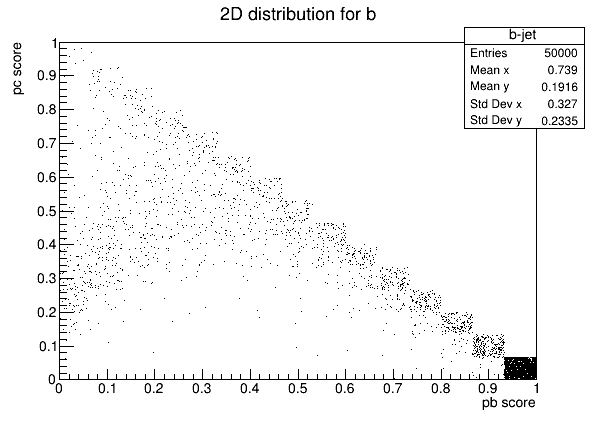

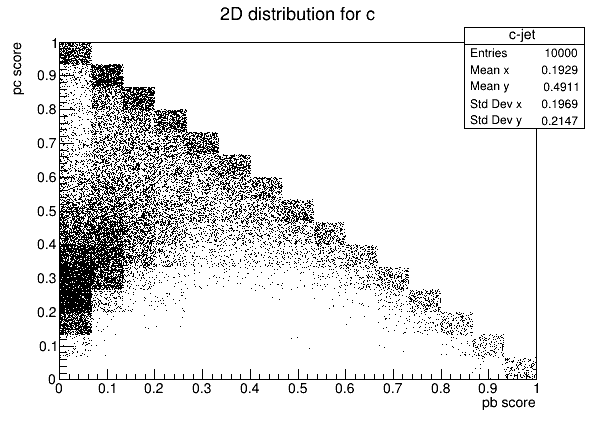

In [7]:
#plot 2d distribution for each jet with 5e4 scales of sample
num = int(5e4)
b = ROOT.TCanvas("b-jet {}".format(num),"The Canvas Title",600,450)
b_2D = ROOT.TH2F("b-jet", "2D distribution for b", 15, 0, 1, 15, 0, 1)
b_2D.FillN(num, b_jet[:, 0], b_jet[:, 1], 1/num*np.ones(num))
b_2D.Draw()
b.cd()
b_2D.GetYaxis().SetTitle("pc score")
b_2D.GetXaxis().SetTitle("pb score")
b.Draw()


num = int((5e4)/5)
c = ROOT.TCanvas("c-jet {}".format(num),"The Canvas Title",600,450)
c_2D = ROOT.TH2F("c-jet", "2D distribution for c", 15, 0, 1, 15, 0, 1)
c_2D.FillN(num, c_jet[:, 0], c_jet[:, 1], 1/num*np.ones(num))
c_2D.Draw()
c.cd()
c_2D.GetYaxis().SetTitle("pc score")
c_2D.GetXaxis().SetTitle("pb score")
c.Draw()


Warning in <TROOT::Append>: Replacing existing TH1: b-jet (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: c-jet (Potential memory leak).


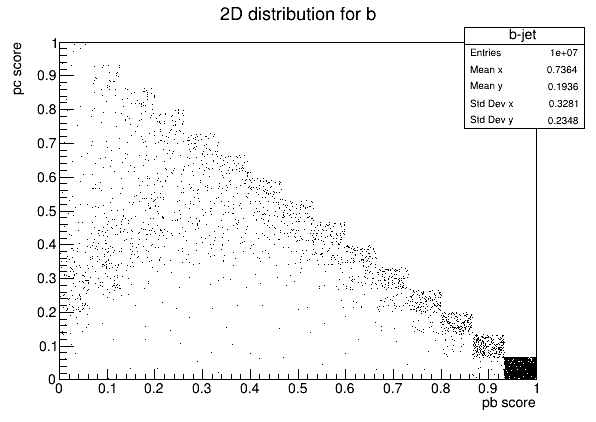

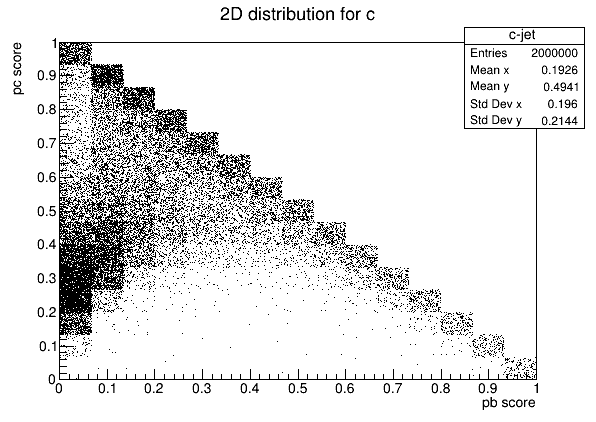

In [8]:
#plot 2d distribution for each jet with 1e5 scales of sample
num = int(1e7)
b = ROOT.TCanvas("b-jet {}".format(num),"The Canvas Title",600,450)
b_2D = ROOT.TH2F("b-jet", "2D distribution for b", 15, 0, 1, 15, 0, 1)
b_2D.FillN(num, b_jet[:, 0], b_jet[:, 1], 1/num*np.ones(num))
b_2D.Draw()
b.cd()
b_2D.GetYaxis().SetTitle("pc score")
b_2D.GetXaxis().SetTitle("pb score")
b.Draw()


num = int((1e7)/5)
c = ROOT.TCanvas("c-jet {}".format(num),"The Canvas Title",600,450)
c_2D = ROOT.TH2F("c-jet", "2D distribution for c", 15, 0, 1, 15, 0, 1)
c_2D.FillN(num, c_jet[:, 0], c_jet[:, 1], 1/num*np.ones(num))
c_2D.Draw()
c.cd()
c_2D.GetYaxis().SetTitle("pc score")
c_2D.GetXaxis().SetTitle("pb score")
c.Draw()


In [9]:
#train test split
X_t, X_test, y_t, y_test = train_test_split(data_X, data_y, test_size=10000000, random_state=114514)

In [10]:
#train validation split
X_train_full, X_vali, y_train_full, y_vali = train_test_split(X_t, y_t, test_size=50000, random_state=114514)
print(y_vali.shape)

(50000,)


### Generate the baseline performance data

In [11]:
#recompute baseline performance
y_baseline = y_test.reshape((y_test.shape[0], 1))
b_jet_test = X_test[y_baseline[:, 0] == 0]
c_jet_test = X_test[y_baseline[:, 0] == 1]

#Calculate ATLAS_score(ln(pc/pb))
b_ATLAS = np.log(np.divide(b_jet_test[:,1], b_jet_test[:,0]))
c_ATLAS = np.log(np.divide(c_jet_test[:,1], c_jet_test[:,0]))

#Calculate CMS_score(pc/(pc+pb))
b_CMS = np.divide(b_jet_test[:,1], b_jet_test[:, 0] + b_jet_test[:, 1])
c_CMS = np.divide(c_jet_test[:,1], c_jet_test[:, 0] + c_jet_test[:, 1])

#Caluculate only pc score
b_pc = b_jet_test[:,1]
c_pc = c_jet_test[:,1]

b_len, c_len = b_jet_test.shape[0], c_jet_test.shape[0] #The total number of each jet

#calculate efficiency for two discriminant method
#ATLAS-score
print(np.max(b_ATLAS), np.min(b_ATLAS), np.max(c_ATLAS), np.min(c_ATLAS))
thresh_ATLAS = np.linspace(-5.45, 3.85, 100)
b_eff_ATLAS = np.array([np.count_nonzero((b_ATLAS > thresh)) for thresh in thresh_ATLAS])/b_len
c_eff_ATLAS = np.array([np.count_nonzero((c_ATLAS > thresh)) for thresh in thresh_ATLAS])/c_len
b_rej_ATLAS = 1/b_eff_ATLAS
print(np.max(b_CMS), np.min(b_CMS), np.max(c_CMS), np.min(c_CMS))
thresh_CMS = np.linspace(0.01, 0.979, 100)
b_eff_CMS = np.array([np.count_nonzero((b_CMS > thresh)) for thresh in thresh_CMS])/b_len
c_eff_CMS = np.array([np.count_nonzero((c_CMS > thresh)) for thresh in thresh_CMS])/c_len
b_rej_CMS = 1/b_eff_CMS

print(np.max(b_pc), np.min(b_pc), np.max(c_pc), np.min(c_pc))
thresh_pc = np.linspace(0.0001, 0.99, 100)
b_eff_pc = np.array([np.count_nonzero((b_pc > thresh)) for thresh in thresh_pc])/b_len
c_eff_pc = np.array([np.count_nonzero((c_pc > thresh)) for thresh in thresh_pc])/c_len
b_rej_pc = 1/b_eff_pc

5.292378111198107 -18.84819027092911 5.780999400298741 -9.815904157698254
0.9949953874846685 6.521311848751205e-09 0.9969238617376472 5.457368599470575e-05
0.9948249 6.5213115e-09 0.99660987 5.4571436e-05


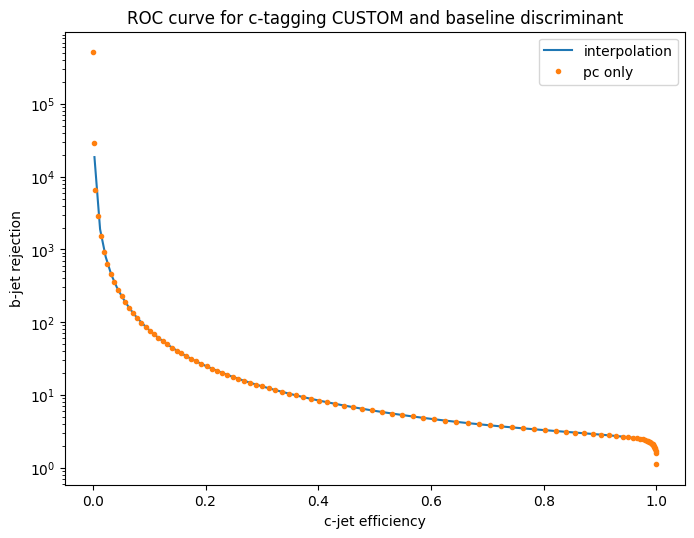

In [99]:
from scipy.interpolate import interp1d

f_ATLAS = interp1d(c_eff_ATLAS, b_rej_ATLAS)
f_pc = interp1d(c_eff_pc, b_rej_pc)
f_CMS = interp1d(c_eff_CMS, b_rej_CMS)

x_space = np.linspace(0.003, 0.99, 100)
plt.figure(figsize=(8,6), dpi=100)

#plt.plot(c_eff_ATLAS, b_rej_ATLAS, ".", label = "ATLAS-like")
#plt.plot(c_eff_CMS, b_rej_CMS, label = "CMS-like")
plt.plot(x_space, f_pc(x_space), label = "interpolation")
plt.plot(c_eff_pc, b_rej_pc, ".", label = "pc only")
plt.yscale("log", base = 10)
plt.xlabel("c-jet efficiency")
plt.ylabel("b-jet rejection")
plt.title("ROC curve for c-tagging CUSTOM and baseline discriminant")
plt.legend()
plt.show()

In [12]:
print(c_jet.shape[0]/(b_jet.shape[0]), b_jet.shape[0]/(b_jet.shape[0]+c_jet.shape[0]))


0.21509357492419073 0.8229818843889366


### Training with 10k samples

epoch = 20, batch size = 256, learning rate = 3e-4, <br>
optimizer: Adam, criterion: BCELoss; model name: model_10k, <br>
exponentially decaying learning rate with gamma = 0.9 <br>

In [13]:
#prepare training dataset
torch.manual_seed(114514)
X_train, y_train = X_train_full[110000:120000, :], y_train_full[110000:120000]

dataset_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
dataset_vali = torch.utils.data.TensorDataset(torch.from_numpy(X_vali), torch.from_numpy(y_vali))

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
print("device:", device)

#set training hyperparameter for training:
epochs = 20
batch_size = 256
learning_rate = 3e-4
num_features = 2 #for this prototyping NN, only use pb and pc as the input features
model_10k = custom1(num_features).to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model_10k.parameters(), lr = learning_rate)
criterion = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
dataloader_vali = torch.utils.data.DataLoader(dataset_vali, batch_size = batch_size, shuffle = True) 

train_accu_lst_10k, vali_accu_lst_10k = [], []
train_loss_lst_10k, vali_loss_lst_10k = [], []
model_10k.train()
for epoch in range(epochs):
    model_10k.train()
    train_losses = []
    for X, y in tqdm.notebook.tqdm(dataloader_train, unit= "batch"):
        optimizer.zero_grad()
        X, y = X.float().to(device), y.float().to(device)
        y = y.view(y.size(0), -1)
        prediction = model_10k(X)
        #reconstruct criterion based on each data label
        #weight = torch.clone(y)
        #weight[weight[:, 0] == 0] = 0.21
        #criterion = nn.BCELoss(weight = weight)
        loss = criterion(prediction, y)

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step()
    mean_loss = np.mean(train_losses)
    train_loss_lst_10k.append(mean_loss)
    print("Finished Epoch", epoch+1, ", training loss:", mean_loss)
    
    #training accuracy
    with torch.no_grad():
        model_10k.eval() #evaluation mode
        accu_list = []
        for train_data in dataloader_train:
            X, y = train_data[0], train_data[1]
            X, y = X.float().to(device), y.float().to(device)
            y = y.view(y.size(0), -1)
            prediction = model_10k(X)

            prediction = np.round(prediction.numpy() + 0.1)
            #accu = np.count_nonzero(prediction == y.numpy())
            accu = sklearn.metrics.balanced_accuracy_score(y.numpy(), prediction)
            accu_list.append(accu)
        model_10k.train()
        train_accu = np.mean(accu_list)
        print("train accu:", train_accu)
        train_accu_lst_10k.append(train_accu)

    #validation accuracy
    with torch.no_grad():
        model_10k.eval()
        #Calculate the validation accuray
        accu_list = []
        validation_losses = []
        for vali_data in dataloader_vali:
            X, y = vali_data[0], vali_data[1]
            X, y = X.float().to(device), y.float().to(device)
            y = y.view(y.size(0), -1)
            
            prediction = model_10k(X)
            loss = criterion(prediction, y)

            prediction = np.round(prediction.numpy() + 0.1)
            #accu = np.count_nonzero(prediction == y.numpy())
            accu = sklearn.metrics.balanced_accuracy_score(y.numpy(), prediction)
            accu_list.append(accu)
            validation_losses.append(loss.item())
        model_10k.train()
        mean_loss = np.mean(validation_losses)
        vali_loss_lst_10k.append(mean_loss)

        vali_accu = np.mean(accu_list)
        print(f"vali accu: {vali_accu}, vali loss: {mean_loss}")
        vali_accu_lst_10k.append(vali_accu)

device: cpu


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 1 , training loss: 0.6060327023267746
train accu: 0.5
vali accu: 0.5, vali loss: 0.5014868669059812


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 2 , training loss: 0.4261153593659401
train accu: 0.5
vali accu: 0.5, vali loss: 0.3783377585362415


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 3 , training loss: 0.3387517064809799
train accu: 0.800895824699818
vali accu: 0.7856239394355886, vali loss: 0.31173902415499394


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 4 , training loss: 0.3019697472453117
train accu: 0.8089063516544941
vali accu: 0.7946668773262465, vali loss: 0.3026657133382194


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 5 , training loss: 0.2983648870140314
train accu: 0.8076774506025657
vali accu: 0.7949306139394211, vali loss: 0.3018013470787175


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 6 , training loss: 0.29101831931620836
train accu: 0.8101854976011682
vali accu: 0.792049764343068, vali loss: 0.30081005500895636


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 7 , training loss: 0.29370833970606325
train accu: 0.7946786861535959
vali accu: 0.7733111380480195, vali loss: 0.3009005113675886


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 8 , training loss: 0.29308839738368986
train accu: 0.7878108377790112
vali accu: 0.7786180160582464, vali loss: 0.29968493523038164


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 9 , training loss: 0.29739624708890916
train accu: 0.8048601231306949
vali accu: 0.7895685534283503, vali loss: 0.3000232830491601


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 10 , training loss: 0.2918404616415501
train accu: 0.7987036856732883
vali accu: 0.7881991564987919, vali loss: 0.29964946522092334


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 11 , training loss: 0.28921520709991455
train accu: 0.7894699552336022
vali accu: 0.7775246463126839, vali loss: 0.2990282891812373


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 12 , training loss: 0.29658682346343995
train accu: 0.7985419250533743
vali accu: 0.7789138021134443, vali loss: 0.2990194966598433


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 13 , training loss: 0.2927987348288298
train accu: 0.802904814538608
vali accu: 0.7836881447115918, vali loss: 0.29869139893930785


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 14 , training loss: 0.2957671798765659
train accu: 0.7974659397994135
vali accu: 0.7796367384893244, vali loss: 0.2987912037999046


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 15 , training loss: 0.2932908069342375
train accu: 0.8026317819664447
vali accu: 0.7835870577012752, vali loss: 0.29876709744638325


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 16 , training loss: 0.2951831005513668
train accu: 0.7969789449031925
vali accu: 0.7815100732685789, vali loss: 0.298589042102804


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 17 , training loss: 0.2903737615793943
train accu: 0.7949210263512393
vali accu: 0.7816925115226884, vali loss: 0.29841979440985894


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 18 , training loss: 0.2955809134989977
train accu: 0.7965006316511019
vali accu: 0.7804940242252093, vali loss: 0.2985934393898565


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 19 , training loss: 0.29564633667469026
train accu: 0.7996627155985091
vali accu: 0.7813624140840238, vali loss: 0.2984215234007154


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 20 , training loss: 0.2931552160531282
train accu: 0.7948827041544779
vali accu: 0.7764340254488035, vali loss: 0.2983333734529359


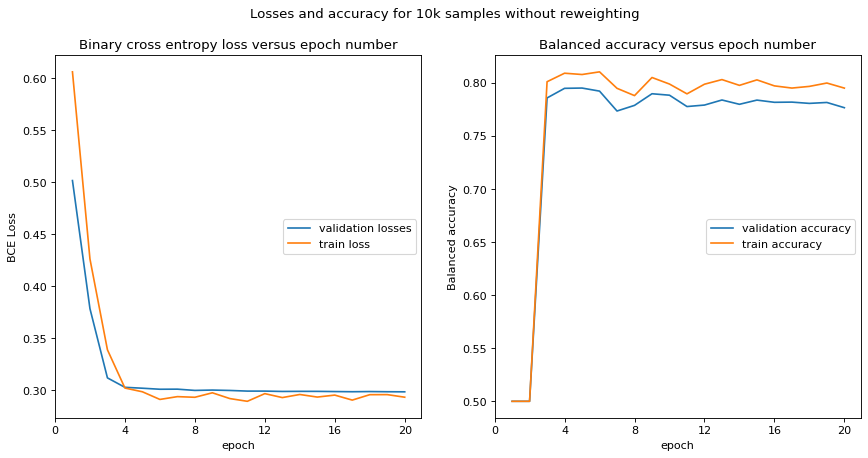

In [14]:
#plot the loss and accuracy versus epoch
epochs = range(1,21)
fig, ax = plt.subplots(1, 2, figsize=(13,6), dpi=80)
fig.suptitle("Losses and accuracy for 10k samples without reweighting")
ax[0].plot(epochs, vali_loss_lst_10k, label = "validation losses")
ax[0].plot(epochs, train_loss_lst_10k, label = "train loss")
ax[0].set_ylabel("BCE Loss")
ax[0].set_xlabel("epoch")
ax[0].set_xticks(np.arange(0,21,4))
ax[0].set_title("Binary cross entropy loss versus epoch number")
ax[0].legend(loc=5)

ax[1].plot(epochs, vali_accu_lst_10k, label = "validation accuracy")
ax[1].plot(epochs, train_accu_lst_10k, label = "train accuracy")
ax[1].set_ylabel("Balanced accuracy")
ax[1].set_xlabel("epoch")
ax[1].set_xticks(np.arange(0,21,4))
ax[1].set_title("Balanced accuracy versus epoch number")
ax[1].legend(loc=5)
plt.show()


In [15]:
#Make prediction on test set with model_10k:
dataset_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size, shuffle = True)
pred_10k = []
with torch.no_grad():
    model_10k.eval()
    for X, y in tqdm.notebook.tqdm(dataloader_test, unit = "batch"):
        X, y = X.float().to(device), y.float().to(device)
        y = y.view(y.size(0), -1)
        output = model_10k(X)
        output = output.numpy()
        y = y.numpy()
        result = np.hstack((output,y))
        pred_10k.append(result)

pred_label_10k = np.concatenate(pred_10k)
print(pred_label_10k.shape)
    

  0%|          | 0/39063 [00:00<?, ?batch/s]

(10000000, 2)


In [16]:
b_CUSTOM1_10k = pred_label_10k[pred_label_10k[:, 1] == 0]
c_CUSTOM1_10k = pred_label_10k[pred_label_10k[:, 1] == 1]
b_len, c_len = b_CUSTOM1_10k.shape[0], c_CUSTOM1_10k.shape[0]
print(np.max(b_CUSTOM1_10k[:,0]), np.min(b_CUSTOM1_10k[:,0]), np.max(c_CUSTOM1_10k[:,0]), np.min(c_CUSTOM1_10k[:,0]))

thresh_CUSTOM1_10k = np.linspace(0.01, 0.66, 100)
b_eff_CUSTOM1_10k = np.array([np.count_nonzero((b_CUSTOM1_10k[:, 0] > thresh)) for thresh in thresh_CUSTOM1_10k])/b_len
c_eff_CUSTOM1_10k = np.array([np.count_nonzero((c_CUSTOM1_10k[:, 0] > thresh)) for thresh in thresh_CUSTOM1_10k])/c_len
b_rej_CUSTOM1_10k = 1/b_eff_CUSTOM1_10k

0.6921877 0.008580186 0.6926347 0.0085836835


In [ ]:
f_custom1_10k = interp1d()
x_space = np.linspace(0.003, 0.99, 100)
plt.figure(figsize=(8,6), dpi=100)

#plt.plot(c_eff_ATLAS, b_rej_ATLAS, ".", label = "ATLAS-like")
#plt.plot(c_eff_CMS, b_rej_CMS, label = "CMS-like")
plt.plot(x_space, f_pc(x_space), label = "interpolation")
plt.plot(c_eff_pc, b_rej_pc, ".", label = "pc only")
plt.yscale("log", base = 10)
plt.xlabel("c-jet efficiency")
plt.ylabel("b-jet rejection")
plt.title("ROC curve for c-tagging CUSTOM and baseline discriminant")
plt.legend()
plt.show()

### Training with 10k samples with reweighting

In [17]:
#prepare training dataset
torch.manual_seed(114514)
X_train, y_train = X_train_full[:10000, :], y_train_full[:10000]

dataset_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
dataset_vali = torch.utils.data.TensorDataset(torch.from_numpy(X_vali), torch.from_numpy(y_vali))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

#set training hyperparameter for training:
epochs = 20
batch_size = 256
learning_rate = 3e-4
num_features = 2 #for this prototyping NN, only use pb and pc as the input features
model_10k_rw = custom1(num_features).to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model_10k_rw.parameters(), lr = learning_rate)
#criterion = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
dataloader_vali = torch.utils.data.DataLoader(dataset_vali, batch_size = batch_size, shuffle = True) 

train_accu_lst_10k_rw, vali_accu_lst_10k_rw = [], []
train_loss_lst_10k_rw, vali_loss_lst_10k_rw = [], []
model_10k_rw.train()
for epoch in range(epochs):
    model_10k_rw.train()
    train_losses = []
    for X, y in tqdm.notebook.tqdm(dataloader_train, unit= "batch"):
        optimizer.zero_grad()
        X, y = X.float().to(device), y.float().to(device)
        y = y.view(y.size(0), -1)
        prediction = model_10k_rw(X)
        #reconstruct criterion based on each data label
        weight = torch.clone(y)
        weight[weight[:, 0] == 0] = 0.21
        criterion = nn.BCELoss(weight = weight)
        loss = criterion(prediction, y)

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step()
    mean_loss = np.mean(train_losses)
    train_loss_lst_10k_rw.append(mean_loss)
    print("Finished Epoch", epoch+1, ", training loss:", mean_loss)
    
    #training accuracy
    with torch.no_grad():
        model_10k_rw.eval() #evaluation mode
        accu_list = []
        for train_data in dataloader_train:
            X, y = train_data[0], train_data[1]
            X, y = X.float().to(device), y.float().to(device)
            y = y.view(y.size(0), -1)
            prediction = model_10k_rw(X)

            prediction = np.round(prediction.numpy() + 0.1)
            #accu = np.count_nonzero(prediction == y.numpy())
            accu = sklearn.metrics.balanced_accuracy_score(y.numpy(), prediction)
            accu_list.append(accu)
        model_10k_rw.train()
        train_accu = np.mean(accu_list)
        print("train accu:", train_accu)
        train_accu_lst_10k_rw.append(train_accu)

    #validation accuracy
    with torch.no_grad():
        model_10k_rw.eval()
        #Calculate the validation accuray
        accu_list = []
        validation_losses = []
        for vali_data in dataloader_vali:
            X, y = vali_data[0], vali_data[1]
            X, y = X.float().to(device), y.float().to(device)
            y = y.view(y.size(0), -1)
            
            prediction = model_10k_rw(X)
            weight = torch.clone(y)
            weight[weight[:, 0] == 0] = 0.21
            criterion = nn.BCELoss(weight = weight)
            loss = criterion(prediction, y)

            prediction = np.round(prediction.numpy() + 0.1)
            #accu = np.count_nonzero(prediction == y.numpy())
            accu = sklearn.metrics.balanced_accuracy_score(y.numpy(), prediction)
            accu_list.append(accu)
            validation_losses.append(loss.item())
        model_10k_rw.train()
        mean_loss = np.mean(validation_losses)
        vali_loss_lst_10k_rw.append(mean_loss)

        vali_accu = np.mean(accu_list)
        print(f"vali accu: {vali_accu}, vali loss: {mean_loss}")
        vali_accu_lst_10k_rw.append(vali_accu)

device: cpu


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 1 , training loss: 0.23131165280938148
train accu: 0.5
vali accu: 0.5, vali loss: 0.21615459747156318


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 2 , training loss: 0.18860837183892726
train accu: 0.820141697001732
vali accu: 0.8174774896965756, vali loss: 0.15632066480359252


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 3 , training loss: 0.1434680424630642
train accu: 0.8237067951922082
vali accu: 0.823953374708782, vali loss: 0.1411130859383515


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 4 , training loss: 0.13925422057509423
train accu: 0.818841245657055
vali accu: 0.8222133565606705, vali loss: 0.14046996295908276


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 5 , training loss: 0.13927780389785765
train accu: 0.8239342974163254
vali accu: 0.8227962564363243, vali loss: 0.13957993442914923


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 6 , training loss: 0.1365723555907607
train accu: 0.8251247019358733
vali accu: 0.822922378714926, vali loss: 0.1391274418909939


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 7 , training loss: 0.13874331638216972
train accu: 0.8261356150260685
vali accu: 0.8235824899095234, vali loss: 0.13881423731087422


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 8 , training loss: 0.1381529675796628
train accu: 0.8262142235821524
vali accu: 0.8235759904895422, vali loss: 0.1385075467429599


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 9 , training loss: 0.14353638365864754
train accu: 0.8183577900738168
vali accu: 0.8239699381637863, vali loss: 0.13845202957793157


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 10 , training loss: 0.1404872452840209
train accu: 0.8256672880872188
vali accu: 0.8236032652794986, vali loss: 0.13845312606771382


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 11 , training loss: 0.1371732072904706


/global/homes/r/ricardom/.conda/envs/root_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


train accu: 0.8173362356998801
vali accu: 0.8233031737164873, vali loss: 0.13827947173647734


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 12 , training loss: 0.13857458606362344
train accu: 0.822860128598766
vali accu: 0.8239349379799392, vali loss: 0.13823648238060426


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 13 , training loss: 0.13673189841210842
train accu: 0.8262650300713688
vali accu: 0.8236943583841119, vali loss: 0.13805777378076192


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 14 , training loss: 0.13912024144083263
train accu: 0.8175718653119144
vali accu: 0.8233489409121946, vali loss: 0.1382330399462763


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 15 , training loss: 0.13592828419059516
train accu: 0.8257209087092591
vali accu: 0.8236158371087063, vali loss: 0.13804578245142285


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 16 , training loss: 0.13743682503700255
train accu: 0.8271231453656285
vali accu: 0.8239634216068339, vali loss: 0.13803454838236984


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 17 , training loss: 0.13783143721520902
train accu: 0.8204525141248766
vali accu: 0.8235576659530045, vali loss: 0.13796214664316908


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 18 , training loss: 0.1370589414611459
train accu: 0.8268511308202958
vali accu: 0.8234944761004986, vali loss: 0.1380428067047377


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 19 , training loss: 0.1365903090685606
train accu: 0.826149487500692
vali accu: 0.8237016820180966, vali loss: 0.1379791720561227


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 20 , training loss: 0.13675870150327682
train accu: 0.8269807039686228
vali accu: 0.8234629149185602, vali loss: 0.1379127565923394


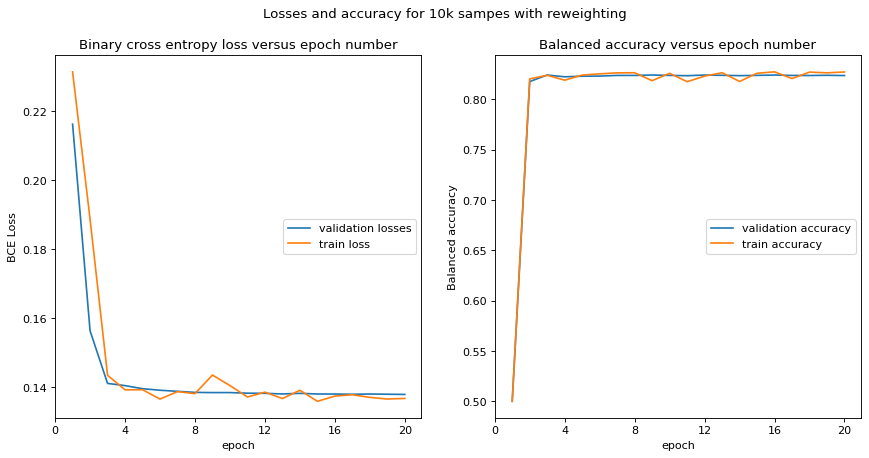

In [18]:
#plot the loss and accuracy versus epoch
epochs = range(1,21)
fig, ax = plt.subplots(1, 2, figsize=(13,6), dpi=80)
fig.suptitle("Losses and accuracy for 10k sampes with reweighting")
ax[0].plot(epochs, vali_loss_lst_10k_rw, label = "validation losses")
ax[0].plot(epochs, train_loss_lst_10k_rw, label = "train loss")
ax[0].set_ylabel("BCE Loss")
ax[0].set_xlabel("epoch")
ax[0].set_xticks(np.arange(0,21,4))
ax[0].set_title("Binary cross entropy loss versus epoch number")
ax[0].legend(loc=5)

ax[1].plot(epochs, vali_accu_lst_10k_rw, label = "validation accuracy")
ax[1].plot(epochs, train_accu_lst_10k_rw, label = "train accuracy")
ax[1].set_ylabel("Balanced accuracy")
ax[1].set_xlabel("epoch")
ax[1].set_xticks(np.arange(0,21,4))
ax[1].set_title("Balanced accuracy versus epoch number")
ax[1].legend(loc=5)
plt.show()

In [19]:
#Make prediction on test set with model_10k:
dataset_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size, shuffle = True)
pred_10k_rw = []
with torch.no_grad():
    model_10k_rw.eval()
    for X, y in tqdm.notebook.tqdm(dataloader_test, unit = "batch"):
        X, y = X.float().to(device), y.float().to(device)
        y = y.view(y.size(0), -1)
        output = model_10k_rw(X)
        output = output.numpy()
        y = y.numpy()
        result = np.hstack((output,y))
        pred_10k_rw.append(result)

pred_label_10k_rw = np.concatenate(pred_10k_rw)
print(pred_label_10k_rw.shape)


  0%|          | 0/39063 [00:00<?, ?batch/s]

(10000000, 2)


In [20]:
b_CUSTOM1_10k_rw = pred_label_10k_rw[pred_label_10k_rw[:, 1] == 0]
c_CUSTOM1_10k_rw = pred_label_10k_rw[pred_label_10k_rw[:, 1] == 1]
b_len, c_len = b_CUSTOM1_10k_rw.shape[0], c_CUSTOM1_10k_rw.shape[0]
print(np.max(b_CUSTOM1_10k_rw[:,0]), np.min(b_CUSTOM1_10k_rw[:,0]), np.max(c_CUSTOM1_10k_rw[:,0]), np.min(c_CUSTOM1_10k_rw[:,0]))

thresh_CUSTOM1_10k_rw = np.linspace(0.02, 0.90, 100)
b_eff_CUSTOM1_10k_rw = np.array([np.count_nonzero((b_CUSTOM1_10k_rw[:, 0] > thresh)) for thresh in thresh_CUSTOM1_10k_rw])/b_len
c_eff_CUSTOM1_10k_rw = np.array([np.count_nonzero((c_CUSTOM1_10k_rw[:, 0] > thresh)) for thresh in thresh_CUSTOM1_10k_rw])/c_len
b_rej_CUSTOM1_10k_rw = 1/b_eff_CUSTOM1_10k_rw

0.9143234 0.03153739 0.9148598 0.031552114


### Draw roc curve to see the performance

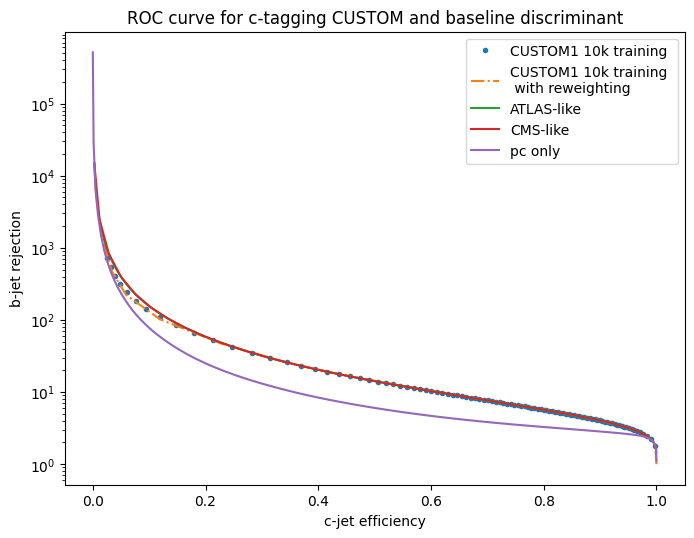

In [21]:
plt.figure(figsize=(8,6), dpi=100)
plt.plot(c_eff_CUSTOM1_10k, b_rej_CUSTOM1_10k, ".", label = "CUSTOM1 10k training")
plt.plot(c_eff_CUSTOM1_10k_rw, b_rej_CUSTOM1_10k_rw, "-.", label = "CUSTOM1 10k training \n with reweighting")
#plt.plot(c_eff_CUSTOM1_100k, b_rej_CUSTOM1_100k, ".", label = "CUSTOM1 100k training \n with reweighting")
plt.plot(c_eff_ATLAS, b_rej_ATLAS,  label = "ATLAS-like")
plt.plot(c_eff_CMS, b_rej_CMS, label = "CMS-like")
plt.plot(c_eff_pc, b_rej_pc, label = "pc only")
plt.yscale("log", base = 10)
plt.xlabel("c-jet efficiency")
plt.ylabel("b-jet rejection")
plt.title("ROC curve for c-tagging CUSTOM and baseline discriminant")
plt.legend()
plt.show()

### Training with 100k samples

In [22]:
#prepare training dataset
torch.manual_seed(114514)
X_train, y_train = X_train_full[10000:110000, :], y_train_full[10000:110000]

dataset_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
dataset_vali = torch.utils.data.TensorDataset(torch.from_numpy(X_vali), torch.from_numpy(y_vali))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

#set training hyperparameter for training:
epochs = 20
batch_size = 256
learning_rate = 3e-4
num_features = 2 #for this prototyping NN, only use pb and pc as the input features
model_100k = custom1(num_features).to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model_100k.parameters(), lr = learning_rate)
criterion = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
dataloader_vali = torch.utils.data.DataLoader(dataset_vali, batch_size = batch_size, shuffle = True) 

train_accu_lst_100k, vali_accu_lst_100k = [], []
train_loss_lst_100k, vali_loss_lst_100k = [], []
model_100k.train()
for epoch in range(epochs):
    model_100k.train()
    train_losses = []
    for X, y in tqdm.notebook.tqdm(dataloader_train, unit= "batch"):
        optimizer.zero_grad()
        X, y = X.float().to(device), y.float().to(device)
        y = y.view(y.size(0), -1)
        prediction = model_100k(X)
        #reconstruct criterion based on each data label
        #weight = torch.clone(y)
        #weight[weight[:, 0] == 0] = 0.21
        #criterion = nn.BCELoss(weight = weight)
        loss = criterion(prediction, y)

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step()
    mean_loss = np.mean(train_losses)
    train_loss_lst_100k.append(mean_loss)
    print("Finished Epoch", epoch+1, ", training loss:", mean_loss)
    
    #training accuracy
    with torch.no_grad():
        model_100k.eval() #evaluation mode
        accu_list = []
        for train_data in dataloader_train:
            X, y = train_data[0], train_data[1]
            X, y = X.float().to(device), y.float().to(device)
            y = y.view(y.size(0), -1)
            prediction = model_100k(X)

            prediction = np.round(prediction.numpy() + 0.1)
            #accu = np.count_nonzero(prediction == y.numpy())
            accu = sklearn.metrics.balanced_accuracy_score(y.numpy(), prediction)
            accu_list.append(accu)
        model_100k.train()
        train_accu = np.mean(accu_list)
        print("train accu:", train_accu)
        train_accu_lst_100k.append(train_accu)

    #validation accuracy
    with torch.no_grad():
        model_100k.eval()
        #Calculate the validation accuray
        accu_list = []
        validation_losses = []
        for vali_data in dataloader_vali:
            X, y = vali_data[0], vali_data[1]
            X, y = X.float().to(device), y.float().to(device)
            y = y.view(y.size(0), -1)
            
            prediction = model_100k(X)
            loss = criterion(prediction, y)

            prediction = np.round(prediction.numpy() + 0.1)
            #accu = np.count_nonzero(prediction == y.numpy())
            accu = sklearn.metrics.balanced_accuracy_score(y.numpy(), prediction)
            accu_list.append(accu)
            validation_losses.append(loss.item())
        model_100k.train()
        mean_loss = np.mean(validation_losses)
        vali_loss_lst_100k.append(mean_loss)

        vali_accu = np.mean(accu_list)
        print(f"vali accu: {vali_accu}, vali loss: {mean_loss}")
        vali_accu_lst_100k.append(vali_accu)

device: cpu


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 1 , training loss: 0.3441833415833276
train accu: 0.7816010206357954
vali accu: 0.7790046037690507, vali loss: 0.29762294941714834


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 2 , training loss: 0.29475928214200015
train accu: 0.7784695023351711
vali accu: 0.775865425084369, vali loss: 0.29543230211248206


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 3 , training loss: 0.29337819518945407
train accu: 0.7718254246338662
vali accu: 0.7697925684325422, vali loss: 0.2946372497446683


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 4 , training loss: 0.29262779050928245
train accu: 0.7647296920932011
vali accu: 0.762036636800227, vali loss: 0.29423738955234996


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 5 , training loss: 0.29209145034670525
train accu: 0.7560284458700981
vali accu: 0.7529590765483613, vali loss: 0.294314301667773


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 6 , training loss: 0.29201995255544666
train accu: 0.7551859981415503
vali accu: 0.7528352938917113, vali loss: 0.2937489165639391


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 7 , training loss: 0.29170825338119744
train accu: 0.7562806678339568
vali accu: 0.7527279582240549, vali loss: 0.2938904497696429


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 8 , training loss: 0.2915600193354785
train accu: 0.7692428894793171
vali accu: 0.7662895967897944, vali loss: 0.29317575320601463


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 9 , training loss: 0.29111323896271496
train accu: 0.7598662561661246
vali accu: 0.7567739800250443, vali loss: 0.2934662267109569


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 10 , training loss: 0.2912165089641386
train accu: 0.7498361014964171
vali accu: 0.7478065003519726, vali loss: 0.29370866708305415


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 11 , training loss: 0.29107646285877814
train accu: 0.7641876442297525
vali accu: 0.760955451350275, vali loss: 0.292829372140826


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 12 , training loss: 0.2909785228998155
train accu: 0.7579188625340716
vali accu: 0.7550711811965077, vali loss: 0.293079070366767


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 13 , training loss: 0.2910021022152718
train accu: 0.7682653273100745
vali accu: 0.7644490499494406, vali loss: 0.29274232906042313


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 14 , training loss: 0.29081670615984045
train accu: 0.7664894018941871
vali accu: 0.7634184448174115, vali loss: 0.29299074168107947


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 15 , training loss: 0.2907160058655702
train accu: 0.7673595575484081
vali accu: 0.7645295752654802, vali loss: 0.2930120764946451


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 16 , training loss: 0.29068248034895533
train accu: 0.7642703808729993
vali accu: 0.7606323054197675, vali loss: 0.2928903476164049


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 17 , training loss: 0.2905912465222961
train accu: 0.7639551458036166
vali accu: 0.7617399744330626, vali loss: 0.2928482360985814


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 18 , training loss: 0.290617443563993
train accu: 0.7586885293524899
vali accu: 0.7537830806624909, vali loss: 0.2930425581123148


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 19 , training loss: 0.2905481929516853
train accu: 0.7596971158289333
vali accu: 0.7560286598270467, vali loss: 0.29289761003182857


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 20 , training loss: 0.29055882513980424
train accu: 0.7659683275088708
vali accu: 0.7634651288856511, vali loss: 0.2928034189556326


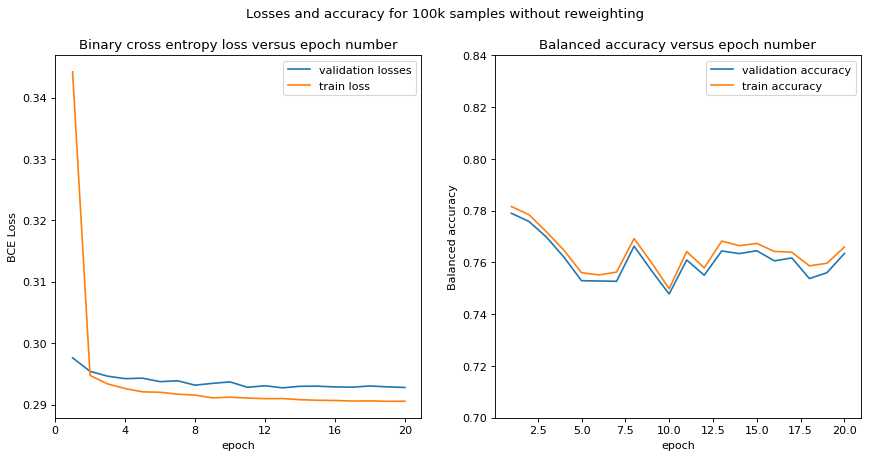

In [23]:
#plot the loss and accuracy versus epoch
epochs = range(1,21)
fig, ax = plt.subplots(1, 2, figsize=(13,6), dpi=80)
fig.suptitle("Losses and accuracy for 100k samples without reweighting")
ax[0].plot(epochs, vali_loss_lst_100k, label = "validation losses")
ax[0].plot(epochs, train_loss_lst_100k, label = "train loss")
ax[0].set_ylabel("BCE Loss")
ax[0].set_xlabel("epoch")
ax[0].set_xticks(np.arange(0,21,4))
ax[0].set_title("Binary cross entropy loss versus epoch number")
ax[0].legend(loc=1)

ax[1].plot(epochs, vali_accu_lst_100k, label = "validation accuracy")
ax[1].plot(epochs, train_accu_lst_100k, label = "train accuracy")
ax[1].set_ylabel("Balanced accuracy")
ax[1].set_ylim(0.7, 0.84)
ax[1].set_xlabel("epoch")
ax[0].set_xticks(np.arange(0,21,4))
ax[1].set_title("Balanced accuracy versus epoch number")
ax[1].legend(loc=1)
plt.show()


In [24]:
#Make prediction on test set with model_100k:
_, X_test, _, y_test = train_test_split(data_X, data_y, test_size=10000000, random_state=114514)
dataset_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size, shuffle = True)
pred_100k = []
with torch.no_grad():
    model_100k.eval()
    for X, y in tqdm.notebook.tqdm(dataloader_test, unit = "batch"):
        X, y = X.float().to(device), y.float().to(device)
        y = y.view(y.size(0), -1)
        output = model_100k(X)
        output = output.numpy()
        y = y.numpy()
        result = np.hstack((output,y))
        pred_100k.append(result)

pred_label_100k = np.concatenate(pred_100k)
print(pred_label_100k.shape)

  0%|          | 0/39063 [00:00<?, ?batch/s]

(10000000, 2)


In [25]:
b_CUSTOM1_100k = pred_label_100k[pred_label_100k[:, 1] == 0]
c_CUSTOM1_100k = pred_label_100k[pred_label_100k[:, 1] == 1]
b_len, c_len = b_CUSTOM1_100k.shape[0], c_CUSTOM1_100k.shape[0]
print(np.max(b_CUSTOM1_100k[:,0]), np.min(b_CUSTOM1_100k[:,0]), np.max(c_CUSTOM1_100k[:,0]), np.min(c_CUSTOM1_100k[:,0]))

thresh_CUSTOM1_100k = np.linspace(0.01, 0.82, 100)
b_eff_CUSTOM1_100k = np.array([np.count_nonzero((b_CUSTOM1_100k[:, 0] > thresh)) for thresh in thresh_CUSTOM1_100k])/b_len
c_eff_CUSTOM1_100k = np.array([np.count_nonzero((c_CUSTOM1_100k[:, 0] > thresh)) for thresh in thresh_CUSTOM1_100k])/c_len
b_rej_CUSTOM1_100k = 1/b_eff_CUSTOM1_100k

0.82056564 0.0017623922 0.8217555 0.0017650594


### Training with 100k sample with reweighting

In [26]:
#prepare training dataset
torch.manual_seed(114514)
X_train, y_train = X_train_full[110000:210000, :], y_train_full[110000:210000]

dataset_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
dataset_vali = torch.utils.data.TensorDataset(torch.from_numpy(X_vali), torch.from_numpy(y_vali))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

#set training hyperparameter for training:
epochs = 20
batch_size = 256
learning_rate = 3e-4
num_features = 2 #for this prototyping NN, only use pb and pc as the input features
model_100k_rw = custom1(num_features).to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model_100k_rw.parameters(), lr = learning_rate)
criterion = nn.BCELoss()
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
dataloader_vali = torch.utils.data.DataLoader(dataset_vali, batch_size = batch_size, shuffle = True) 

train_accu_lst_100k_rw, vali_accu_lst_100k_rw = [], []
train_loss_lst_100k_rw, vali_loss_lst_100k_rw = [], []
model_100k_rw.train()
for epoch in range(epochs):
    model_100k_rw.train()
    train_losses = []
    for X, y in tqdm.notebook.tqdm(dataloader_train, unit= "batch"):
        optimizer.zero_grad()
        X, y = X.float().to(device), y.float().to(device)
        y = y.view(y.size(0), -1)
        prediction = model_100k_rw(X)
        #reconstruct criterion based on each data label
        weight = torch.clone(y)
        weight[weight[:, 0] == 0] = 0.21
        criterion = nn.BCELoss(weight = weight)
        loss = criterion(prediction, y)

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    #scheduler.step()
    mean_loss = np.mean(train_losses)
    train_loss_lst_100k_rw.append(mean_loss)
    print("Finished Epoch", epoch+1, ", training loss:", mean_loss)
    
    #training accuracy
    with torch.no_grad():
        model_100k_rw.eval() #evaluation mode
        accu_list = []
        for train_data in dataloader_train:
            X, y = train_data[0], train_data[1]
            X, y = X.float().to(device), y.float().to(device)
            y = y.view(y.size(0), -1)
            prediction = model_100k_rw(X)

            prediction = np.round(prediction.numpy() + 0.1)
            #accu = np.count_nonzero(prediction == y.numpy())
            accu = sklearn.metrics.balanced_accuracy_score(y.numpy(), prediction)
            accu_list.append(accu)
        model_100k_rw.train()
        train_accu = np.mean(accu_list)
        print("train accu:", train_accu)
        train_accu_lst_100k_rw.append(train_accu)

    #validation accuracy
    with torch.no_grad():
        model_100k_rw.eval()
        #Calculate the validation accuray
        accu_list = []
        validation_losses = []
        for vali_data in dataloader_vali:
            X, y = vali_data[0], vali_data[1]
            X, y = X.float().to(device), y.float().to(device)
            y = y.view(y.size(0), -1)
            
            prediction = model_100k_rw(X)
            weight = torch.clone(y)
            weight[weight[:, 0] == 0] = 0.21
            criterion = nn.BCELoss(weight = weight)
            loss = criterion(prediction, y)

            prediction = np.round(prediction.numpy() + 0.1)
            #accu = np.count_nonzero(prediction == y.numpy())
            accu = sklearn.metrics.balanced_accuracy_score(y.numpy(), prediction)
            accu_list.append(accu)
            validation_losses.append(loss.item())
        model_100k_rw.train()
        mean_loss = np.mean(validation_losses)
        vali_loss_lst_100k_rw.append(mean_loss)

        vali_accu = np.mean(accu_list)
        print(f"vali accu: {vali_accu}, vali loss: {mean_loss}")
        vali_accu_lst_100k_rw.append(vali_accu)

device: cpu


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 1 , training loss: 0.1521611428436111
train accu: 0.8252029099845504
vali accu: 0.8234588179653558, vali loss: 0.1375127450315928


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 2 , training loss: 0.13614571365096684
train accu: 0.8164856941993626
vali accu: 0.8156900889061457, vali loss: 0.13805456064185317


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 3 , training loss: 0.1350225394453539
train accu: 0.8237925937290878
vali accu: 0.8223762606376154, vali loss: 0.13573091051408223


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 4 , training loss: 0.13453206096006476
train accu: 0.8247352150770194
vali accu: 0.8233745611127011, vali loss: 0.1356328528906618


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 5 , training loss: 0.13422695396806272
train accu: 0.8202761109868609
vali accu: 0.8198278053035177, vali loss: 0.1350226064725798


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 6 , training loss: 0.13398088147039608
train accu: 0.8206407302732259
vali accu: 0.8195734737174836, vali loss: 0.1347429472953081


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 7 , training loss: 0.13392312571292034
train accu: 0.8224324044928958
vali accu: 0.821774039700307, vali loss: 0.13509383151421742


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 8 , training loss: 0.13378733979619067
train accu: 0.8202620049827147
vali accu: 0.81964166649709, vali loss: 0.13493921299826125


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 9 , training loss: 0.13383251440037242
train accu: 0.8226584714598975
vali accu: 0.8221438195726974, vali loss: 0.13461788116517115


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 10 , training loss: 0.13360700872548095
train accu: 0.8258993410825558
vali accu: 0.8236451692800771, vali loss: 0.1356378506717025


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 11 , training loss: 0.13366396860469637
train accu: 0.821440606621336
vali accu: 0.8203629369339922, vali loss: 0.13471235878461477


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 12 , training loss: 0.13356310807530533
train accu: 0.8215003329810253
vali accu: 0.8211529013777299, vali loss: 0.13462581964475767


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 13 , training loss: 0.13353075235700973
train accu: 0.8207715124537561
vali accu: 0.8199897579035829, vali loss: 0.1344164730030663


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 14 , training loss: 0.13360810075955623
train accu: 0.8216751550310464
vali accu: 0.8211215656755275, vali loss: 0.13453703350862678


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 15 , training loss: 0.13345514014934945
train accu: 0.8225289362493905
vali accu: 0.8215233384325668, vali loss: 0.13471906027775638


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 16 , training loss: 0.13346467281470215
train accu: 0.8190839672629663
vali accu: 0.8179412294111661, vali loss: 0.13500156561482926


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 17 , training loss: 0.13346561711386343
train accu: 0.8198349038804627
vali accu: 0.8190100736929378, vali loss: 0.13447986090821878


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 18 , training loss: 0.13357533455428566
train accu: 0.8197329745599239
vali accu: 0.8186210197172675, vali loss: 0.1348729924659948


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 19 , training loss: 0.13342307885284618
train accu: 0.8222699970590078
vali accu: 0.8213418020519075, vali loss: 0.13440677299335294


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 20 , training loss: 0.13336834189532054
train accu: 0.817253317895709
vali accu: 0.8174053624663599, vali loss: 0.13500642993164305


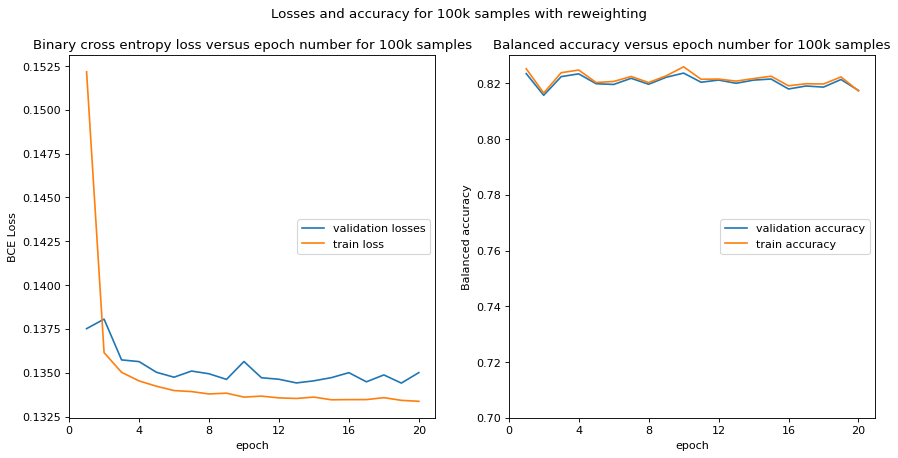

In [27]:
#plot the loss and accuracy versus epoch
epochs = range(1,21)
fig, ax = plt.subplots(1, 2, figsize=(13,6), dpi=80)
fig.suptitle("Losses and accuracy for 100k samples with reweighting")
ax[0].plot(epochs, vali_loss_lst_100k_rw, label = "validation losses")
ax[0].plot(epochs, train_loss_lst_100k_rw, label = "train loss")
ax[0].set_ylabel("BCE Loss")
ax[0].set_xlabel("epoch")
ax[0].set_xticks(np.arange(0,21,4))
ax[0].set_title("Binary cross entropy loss versus epoch number for 100k samples")
ax[0].legend(loc=5)

ax[1].plot(epochs, vali_accu_lst_100k_rw, label = "validation accuracy")
ax[1].plot(epochs, train_accu_lst_100k_rw, label = "train accuracy")
ax[1].set_ylim(0.7, 0.83)
ax[1].set_ylabel("Balanced accuracy")
ax[1].set_xlabel("epoch")
ax[1].set_xticks(np.arange(0,21,4))
ax[1].set_title("Balanced accuracy versus epoch number for 100k samples")
ax[1].legend(loc=5)
plt.show()

In [28]:
#Make prediction on test set with model_100k:
_, X_test, _, y_test = train_test_split(data_X, data_y, test_size=10000000, random_state=114514)
dataset_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size, shuffle = True)
pred_100k_rw = []
with torch.no_grad():
    model_100k_rw.eval()
    for X, y in tqdm.notebook.tqdm(dataloader_test, unit = "batch"):
        X, y = X.float().to(device), y.float().to(device)
        y = y.view(y.size(0), -1)
        output = model_100k_rw(X)
        output = output.numpy()
        y = y.numpy()
        result = np.hstack((output,y))
        pred_100k_rw.append(result)

pred_label_100k_rw = np.concatenate(pred_100k_rw)
print(pred_label_100k_rw.shape)

  0%|          | 0/39063 [00:00<?, ?batch/s]

(10000000, 2)


In [29]:
b_CUSTOM1_100k_rw = pred_label_100k_rw[pred_label_100k_rw[:, 1] == 0]
c_CUSTOM1_100k_rw = pred_label_100k_rw[pred_label_100k_rw[:, 1] == 1]
b_len, c_len = b_CUSTOM1_100k_rw.shape[0], c_CUSTOM1_100k_rw.shape[0]
print(np.max(b_CUSTOM1_100k_rw[:,0]), np.min(b_CUSTOM1_100k_rw[:,0]), np.max(c_CUSTOM1_100k_rw[:,0]), np.min(c_CUSTOM1_100k_rw[:,0]))

thresh_CUSTOM1_100k_rw = np.linspace(0.01, 0.94, 100)
b_eff_CUSTOM1_100k_rw = np.array([np.count_nonzero((b_CUSTOM1_100k_rw[:, 0] > thresh)) for thresh in thresh_CUSTOM1_100k_rw])/b_len
c_eff_CUSTOM1_100k_rw = np.array([np.count_nonzero((c_CUSTOM1_100k_rw[:, 0] > thresh)) for thresh in thresh_CUSTOM1_100k_rw])/c_len
b_rej_CUSTOM1_100k_rw = 1/b_eff_CUSTOM1_100k_rw

0.96365756 0.002252487 0.9640968 0.00226257


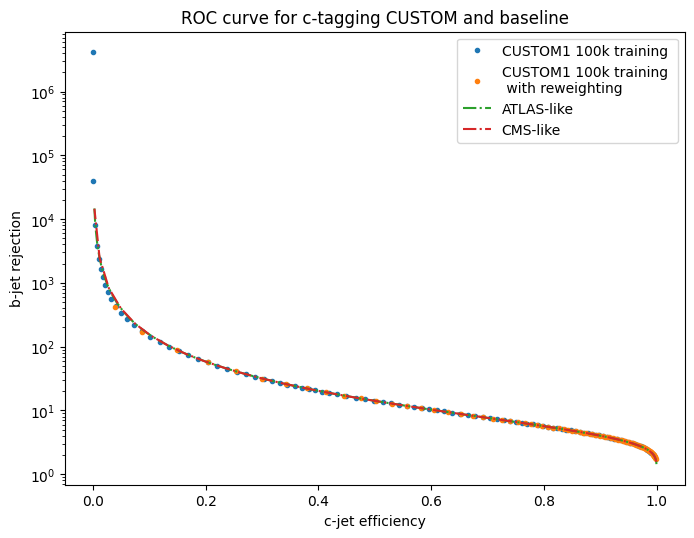

In [30]:
plt.figure(figsize=(8,6), dpi=100)
plt.plot(c_eff_CUSTOM1_100k, b_rej_CUSTOM1_100k, ".", label = "CUSTOM1 100k training")
plt.plot(c_eff_CUSTOM1_100k_rw, b_rej_CUSTOM1_100k_rw, ".", label = "CUSTOM1 100k training \n with reweighting")
#plt.plot(c_eff_CUSTOM1_100k, b_rej_CUSTOM1_100k, ".", label = "CUSTOM1 100k training \n with reweighting")
#plt.plot(c_eff_CUSTOM1w, b_rej_CUSTOM1w, label = "CUSTOM1 without reweighting")
plt.plot(c_eff_ATLAS, b_rej_ATLAS, "-.",  label = "ATLAS-like")
plt.plot(c_eff_CMS, b_rej_CMS, "-.", label = "CMS-like")
plt.yscale("log", base = 10)
plt.xlabel("c-jet efficiency")
plt.ylabel("b-jet rejection")
plt.title("ROC curve for c-tagging CUSTOM and baseline")
plt.legend()
plt.show()

In [65]:
### curve fitting function:
from scipy.interpolate import interp1d


### Training with other hyperparameter with 100k samples


In [31]:
#construct the model
class custom2(nn.Module):
    def __init__(self, in_dim) -> None:
        super().__init__()
        self.input = nn.Linear(in_dim, 100)
        self.layer0 = nn.Linear(100, 75)
        self.layer1 = nn.Linear(75,75)
        self.layer2 = nn.Linear(75,50)
        self.output = nn.Linear(50, 1)

    def forward(self, x):
        x = nn.ReLU()(self.input(x))
        x = nn.Tanh()(self.layer0(x))
        x = nn.RReLU()(self.layer1(x))
        x = nn.Dropout(p=0.4)(x)
        x = nn.Tanh()(self.layer2(x))
        output = nn.Sigmoid()(self.output(x))
        return output


In [50]:
#prepare training dataset
torch.manual_seed(114514)
X_train, y_train = X_train_full[110000:210000, :], y_train_full[110000:210000]
y_ind = y_train.reshape(100000,1)
b_mean, b_std = np.mean(X_train[y_ind[:,0] == 0], axis = 0), np.std(X_train[y_ind[:,0] == 0], axis = 0)
c_mean, c_std = np.mean(X_train[y_ind[:,0] == 1], axis = 0), np.std(X_train[y_ind[:,0] == 1], axis = 0)
X_train[y_ind[:,0] == 0] = (X_train[y_ind[:,0] == 0]-b_mean)/b_std
X_train[y_ind[:,0] == 1] = (X_train[y_ind[:,0] == 1]-c_mean)/c_std

dataset_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
dataset_vali = torch.utils.data.TensorDataset(torch.from_numpy(X_vali), torch.from_numpy(y_vali))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

#set training hyperparameter for training:
epochs = 20
batch_size = 256
learning_rate = 3e-4
num_features = 2 #for this prototyping NN, only use pb and pc as the input features
model2_100k = custom2(num_features).to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model2_100k.parameters(), lr = learning_rate)
criterion = nn.BCELoss()
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
dataloader_vali = torch.utils.data.DataLoader(dataset_vali, batch_size = batch_size, shuffle = True) 

train_accu_lst2_100k, vali_accu_lst2_100k = [], []
train_loss_lst2_100k, vali_loss_lst2_100k = [], []
model2_100k.train()
for epoch in range(epochs):
    model2_100k.train()
    train_losses = []
    for X, y in tqdm.notebook.tqdm(dataloader_train, unit= "batch"):
        optimizer.zero_grad()
        X, y = X.float().to(device), y.float().to(device)
        y = y.view(y.size(0), -1)
        prediction = model2_100k(X)
        #reconstruct criterion based on each data label
        weight = torch.clone(y)
        weight[weight[:, 0] == 0] = 0.21
        criterion = nn.BCELoss(weight = weight)
        loss = criterion(prediction, y)

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    #scheduler.step()
    mean_loss = np.mean(train_losses)
    train_loss_lst2_100k.append(mean_loss)
    print("Finished Epoch", epoch+1, ", training loss:", mean_loss)
    
    #training accuracy
    with torch.no_grad():
        model2_100k.eval() #evaluation mode
        accu_list = []
        for train_data in dataloader_train:
            X, y = train_data[0], train_data[1]
            X, y = X.float().to(device), y.float().to(device)
            y = y.view(y.size(0), -1)
            prediction = model2_100k(X)

            prediction = np.round(prediction.numpy() + 0.1)
            #accu = np.count_nonzero(prediction == y.numpy())
            accu = sklearn.metrics.balanced_accuracy_score(y.numpy(), prediction)
            accu_list.append(accu)
        model2_100k.train()
        train_accu = np.mean(accu_list)
        print("train accu:", train_accu)
        train_accu_lst2_100k.append(train_accu)

    #validation accuracy
    with torch.no_grad():
        model2_100k.eval()
        #Calculate the validation accuray
        accu_list = []
        validation_losses = []
        for vali_data in dataloader_vali:
            X, y = vali_data[0], vali_data[1]
            X, y = X.float().to(device), y.float().to(device)
            y = y.view(y.size(0), -1)
            
            prediction = model2_100k(X)
            weight = torch.clone(y)
            weight[weight[:, 0] == 0] = 0.21
            criterion = nn.BCELoss(weight = weight)
            loss = criterion(prediction, y)

            prediction = np.round(prediction.numpy() + 0.1)
            #accu = np.count_nonzero(prediction == y.numpy())
            accu = sklearn.metrics.balanced_accuracy_score(y.numpy(), prediction)
            accu_list.append(accu)
            validation_losses.append(loss.item())
        model2_100k.train()
        mean_loss = np.mean(validation_losses)
        vali_loss_lst2_100k.append(mean_loss)

        vali_accu = np.mean(accu_list)
        print(f"vali accu: {vali_accu}, vali loss: {mean_loss}")
        vali_accu_lst2_100k.append(vali_accu)

device: cpu


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 1 , training loss: 0.08677781192238068
train accu: 0.9601771358411832
vali accu: 0.4033694751854011, vali loss: 0.9919166701788805


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 2 , training loss: 0.03421146008888703
train accu: 0.9647025572959524
vali accu: 0.42679294023955944, vali loss: 1.3263679566432018


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 3 , training loss: 0.030500794448854063
train accu: 0.9676737004549583
vali accu: 0.42917770164905106, vali loss: 1.4840156575854944


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 4 , training loss: 0.029034790126821194
train accu: 0.9682935816250893
vali accu: 0.44615133824432557, vali loss: 1.5694098296214123


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 5 , training loss: 0.02876085479317419
train accu: 0.9688663936193906
vali accu: 0.44062117518277877, vali loss: 1.6277006152941256


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 6 , training loss: 0.02762310971003359
train accu: 0.968406407632345
vali accu: 0.45362640734485943, vali loss: 1.6569174485547202


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 7 , training loss: 0.02662258526629499
train accu: 0.952989591213626
vali accu: 0.4692266497556515, vali loss: 1.7082194436569602


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 8 , training loss: 0.02683297698350285
train accu: 0.9686884462323506
vali accu: 0.43875844932616603, vali loss: 1.7513270876845535


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 9 , training loss: 0.02667448758993231
train accu: 0.9683028371573111
vali accu: 0.4560360357255622, vali loss: 1.7246629443703865


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 10 , training loss: 0.02634991668498196
train accu: 0.969409298993195
vali accu: 0.4591437724531367, vali loss: 1.7462649643421173


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 11 , training loss: 0.026141854458014525
train accu: 0.9701770514185886
vali accu: 0.4520040429370932, vali loss: 1.7682692822144956


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 12 , training loss: 0.025900778932320644
train accu: 0.9702473256578735
vali accu: 0.4585145052978769, vali loss: 1.770312909569059


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 13 , training loss: 0.026643709448711646
train accu: 0.9698441161202742
vali accu: 0.4513895805121819, vali loss: 1.7325257482577343


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 14 , training loss: 0.025670731017399397
train accu: 0.9678265719811214
vali accu: 0.45295893247970836, vali loss: 1.7530723159410515


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 15 , training loss: 0.025602085336023355
train accu: 0.9690935220121568
vali accu: 0.4548114132320424, vali loss: 1.7521767166196083


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 16 , training loss: 0.025705398141365986
train accu: 0.969656221562608
vali accu: 0.45272073796333856, vali loss: 1.7783701292106084


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 17 , training loss: 0.025427481613319626
train accu: 0.9693392133940238
vali accu: 0.45384075895865356, vali loss: 1.7605621291666615


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 18 , training loss: 0.02537181051721906
train accu: 0.970374008341371
vali accu: 0.45769914296832936, vali loss: 1.7575189769268036


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 19 , training loss: 0.025285863356850565
train accu: 0.9701963563542156
vali accu: 0.454678163486661, vali loss: 1.7610762362577477


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 20 , training loss: 0.025258784826673434
train accu: 0.968661131890853
vali accu: 0.4611958481509546, vali loss: 1.7641352415084839


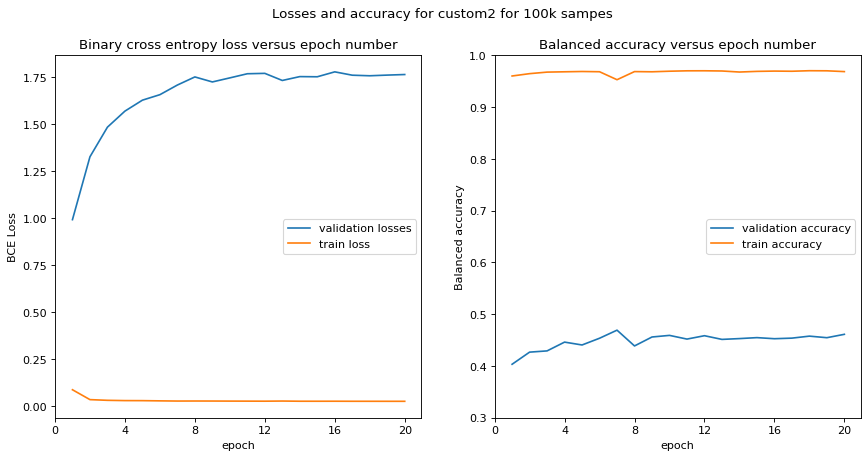

In [55]:
#plot the loss and accuracy versus epoch
epochs = range(1,21)
fig, ax = plt.subplots(1, 2, figsize=(13,6), dpi=80)
fig.suptitle("Losses and accuracy for custom2 for 100k sampes ")
ax[0].plot(epochs, vali_loss_lst2_100k, label = "validation losses")
ax[0].plot(epochs, train_loss_lst2_100k, label = "train loss")
ax[0].set_ylabel("BCE Loss")
ax[0].set_xlabel("epoch")
ax[0].set_xticks(np.arange(0,21,4))
ax[0].set_title("Binary cross entropy loss versus epoch number")
ax[0].legend(loc=5)

ax[1].plot(epochs, vali_accu_lst2_100k, label = "validation accuracy")
ax[1].plot(epochs, train_accu_lst2_100k, label = "train accuracy")
ax[1].set_ylabel("Balanced accuracy")
ax[1].set_xlabel("epoch")
ax[1].set_ylim(0.3, 1)
ax[1].set_xticks(np.arange(0,21,4))
ax[1].set_title("Balanced accuracy versus epoch number")
ax[1].legend(loc=5)
plt.show()

In [56]:
#Make prediction on test set with model_10k:
_, X_test, _, y_test = train_test_split(data_X, data_y, test_size=10000000, random_state=114514)
dataset_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size, shuffle = True)
pred2_100k = []
with torch.no_grad():
    model2_100k.eval()
    for X, y in tqdm.notebook.tqdm(dataloader_test, unit = "batch"):
        X, y = X.float().to(device), y.float().to(device)
        y = y.view(y.size(0), -1)
        output = model2_100k(X)
        output = output.numpy()
        y = y.numpy()
        result = np.hstack((output,y))
        pred2_100k.append(result)

pred_label2_100k = np.concatenate(pred2_100k)
print(pred_label2_100k.shape)

  0%|          | 0/39063 [00:00<?, ?batch/s]

(10000000, 2)


In [58]:
b_CUSTOM2_100k = pred_label2_100k[pred_label2_100k[:, 1] == 0]
c_CUSTOM2_100k = pred_label2_100k[pred_label2_100k[:, 1] == 1]
b_len, c_len = b_CUSTOM2_100k.shape[0], c_CUSTOM2_100k.shape[0]
print(np.max(b_CUSTOM2_100k[:,0]), np.min(b_CUSTOM2_100k[:,0]), np.max(c_CUSTOM2_100k[:,0]), np.min(c_CUSTOM2_100k[:,0]))

thresh_CUSTOM2_100k = np.linspace(0.01, 0.98, 100)
b_eff_CUSTOM2_100k = np.array([np.count_nonzero((b_CUSTOM2_100k[:, 0] > thresh)) for thresh in thresh_CUSTOM2_100k])/b_len
c_eff_CUSTOM2_100k = np.array([np.count_nonzero((c_CUSTOM2_100k[:, 0] > thresh)) for thresh in thresh_CUSTOM2_100k])/c_len
b_rej_CUSTOM2_100k = 1/b_eff_CUSTOM2_100k

0.9999645 0.022270834 0.9999645 0.022958772


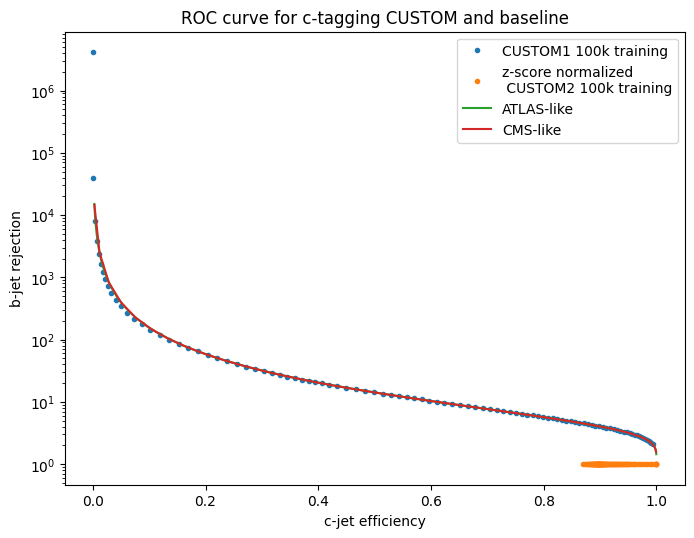

In [64]:
plt.figure(figsize=(8,6), dpi=100)
plt.plot(c_eff_CUSTOM1_100k, b_rej_CUSTOM1_100k, ".", label = "CUSTOM1 100k training")
#plt.plot(c_eff_CUSTOM1_10k, b_rej_CUSTOM1_10k, ".", label = "CUSTOM1 10k training")
plt.plot(c_eff_CUSTOM2_100k, b_rej_CUSTOM2_100k, ".", label = "z-score normalized \n CUSTOM2 100k training")
#plt.plot(c_eff_CUSTOM1w, b_rej_CUSTOM1w, label = "CUSTOM1 without reweighting")
plt.plot(c_eff_ATLAS, b_rej_ATLAS, label = "ATLAS-like")
plt.plot(c_eff_CMS, b_rej_CMS, label = "CMS-like")
plt.yscale("log", base = 10)
plt.xlabel("c-jet efficiency")
plt.ylabel("b-jet rejection")
plt.title("ROC curve for c-tagging CUSTOM and baseline")
plt.legend()
plt.show()

### Three input model

In [36]:
b_jet_3 = (pd.read_csv("/global/cscratch1/sd/ricardom/b_jet_3output.csv")).to_numpy()
c_jet_3 = (pd.read_csv("/global/cscratch1/sd/ricardom/c_jet_3output.csv")).to_numpy()
l_jet_3 = (pd.read_csv("/global/cscratch1/sd/ricardom/light_jet_3output.csv")).to_numpy()
data_X_3 = np.concatenate((b_jet_3, c_jet_3)) #data
#creating label for c_jet and b_jet: c -> 1, b -> 0
b_label_3 = np.zeros((b_jet.shape[0]))
c_label_3 = np.ones((c_jet.shape[0]))
l_label_3 = 15*np.ones((l_jet_3.shape[0]))
data_y_3 = np.concatenate((b_label_3, c_label_3)) #label for data

In [37]:
#train validation split
X_train_full_3, X_vali_3, y_train_full_3, y_vali_3 = train_test_split(data_X_3, data_y_3, test_size=50000, random_state=114514)
print(y_vali.shape)

(50000,)


In [38]:
#construct the model
class custom3(nn.Module):
    def __init__(self, in_dim) -> None:
        super().__init__()
        self.input = nn.Linear(in_dim, 100)
        self.layer0 = nn.Linear(100, 75)
        self.layer1 = nn.Linear(75,75)
        self.layer2 = nn.Linear(75,50)
        self.output = nn.Linear(50, 1)

    def forward(self, x):
        x = nn.ReLU()(self.input(x))
        x = nn.Tanh()(self.layer0(x))
        x = nn.ReLU()(self.layer1(x))
        x = nn.Dropout(p=0.2)(x)
        x = nn.Tanh()(self.layer2(x))
        output = nn.Sigmoid()(self.output(x))
        return output


In [45]:
#prepare training dataset
torch.manual_seed(114514)
X_train_3, y_train_3 = X_train_full_3[110000:210000, :], y_train_full_3[110000:210000]
X_train_3[:, 2] = X_train_3[:, 1]/(X_train_3[:, 0])

dataset_train_3 = torch.utils.data.TensorDataset(torch.from_numpy(X_train_3), torch.from_numpy(y_train_3))
dataset_vali_3 = torch.utils.data.TensorDataset(torch.from_numpy(X_vali_3), torch.from_numpy(y_vali_3))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

#set training hyperparameter for training:
epochs = 20
batch_size = 256
learning_rate = 3e-4
num_features = 3 #for this prototyping NN, only use pb and pc as the input features
model3_100k = custom3(num_features).to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model3_100k.parameters(), lr = learning_rate)
criterion = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
dataloader_train_3 = torch.utils.data.DataLoader(dataset_train_3, batch_size = batch_size, shuffle = True)
dataloader_vali_3 = torch.utils.data.DataLoader(dataset_vali_3, batch_size = batch_size, shuffle = True) 

train_accu_lst3_100k, vali_accu_lst3_100k = [], []
train_loss_lst3_100k, vali_loss_lst3_100k = [], []
model3_100k.train()
for epoch in range(epochs):
    model3_100k.train()
    train_losses = []
    for X, y in tqdm.notebook.tqdm(dataloader_train_3, unit= "batch"):
        optimizer.zero_grad()
        X, y = X.float().to(device), y.float().to(device)
        y = y.view(y.size(0), -1)
        prediction = model3_100k(X)
        #reconstruct criterion based on each data label
        #weight = torch.clone(y)
        #weight[weight[:, 0] == 0] = 0.21
        #criterion = nn.BCELoss(weight = weight)
        loss = criterion(prediction, y)

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    #scheduler.step()
    mean_loss = np.mean(train_losses)
    train_loss_lst3_100k.append(mean_loss)
    print("Finished Epoch", epoch+1, ", training loss:", mean_loss)
    
    #training accuracy
    with torch.no_grad():
        model3_100k.eval() #evaluation mode
        accu_list = []
        for train_data in dataloader_train_3:
            X, y = train_data[0], train_data[1]
            X, y = X.float().to(device), y.float().to(device)
            y = y.view(y.size(0), -1)
            prediction = model3_100k(X)

            prediction = np.round(prediction.numpy() + 0.1)
            #accu = np.count_nonzero(prediction == y.numpy())
            accu = sklearn.metrics.balanced_accuracy_score(y.numpy(), prediction)
            accu_list.append(accu)
        model3_100k.train()
        train_accu = np.mean(accu_list)
        print("train accu:", train_accu)
        train_accu_lst3_100k.append(train_accu)

    #validation accuracy
    with torch.no_grad():
        model3_100k.eval()
        #Calculate the validation accuray
        accu_list = []
        validation_losses = []
        for vali_data in dataloader_vali_3:
            X, y = vali_data[0], vali_data[1]
            X, y = X.float().to(device), y.float().to(device)
            y = y.view(y.size(0), -1)
            
            prediction = model3_100k(X)
            #weight = torch.clone(y)
            #weight[weight[:, 0] == 0] = 0.21
            #criterion = nn.BCELoss(weight = weight)
            loss = criterion(prediction, y)

            prediction = np.round(prediction.numpy() + 0.1)
            #accu = np.count_nonzero(prediction == y.numpy())
            accu = sklearn.metrics.balanced_accuracy_score(y.numpy(), prediction)
            accu_list.append(accu)
            validation_losses.append(loss.item())
        model3_100k.train()
        mean_loss = np.mean(validation_losses)
        vali_loss_lst3_100k.append(mean_loss)

        vali_accu = np.mean(accu_list)
        print(f"vali accu: {vali_accu}, vali loss: {mean_loss}")
        vali_accu_lst3_100k.append(vali_accu)

device: cpu


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 1 , training loss: 0.33545337518310303
train accu: 0.7264563990566495
vali accu: 0.5, vali loss: 0.394867013303601


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 2 , training loss: 0.2959735516239615
train accu: 0.7409993146645183
vali accu: 0.5, vali loss: 0.3715059843902685


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 3 , training loss: 0.2944469267831129
train accu: 0.768352755388279
vali accu: 0.5, vali loss: 0.37636155984839614


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 4 , training loss: 0.29338209613052474
train accu: 0.7446578901152582
vali accu: 0.5, vali loss: 0.38219642335054826


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 5 , training loss: 0.2929099555820455
train accu: 0.7545683165458527
vali accu: 0.5, vali loss: 0.36841802040533145


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 6 , training loss: 0.2927803388794365
train accu: 0.7721432539575019
vali accu: 0.5, vali loss: 0.3648383857644334


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 7 , training loss: 0.2926759307875353
train accu: 0.7877682327126535
vali accu: 0.5, vali loss: 0.3538517442588903


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 8 , training loss: 0.2923838858256864
train accu: 0.782109688984596
vali accu: 0.5, vali loss: 0.36651817313870605


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 9 , training loss: 0.29241284602285955
train accu: 0.772138624348741
vali accu: 0.5, vali loss: 0.3757642090928798


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 10 , training loss: 0.29232429025118306
train accu: 0.7813811768973288
vali accu: 0.5, vali loss: 0.3559474827987807


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 11 , training loss: 0.29231762032374703
train accu: 0.7705904634508123
vali accu: 0.5, vali loss: 0.3700127216170029


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 12 , training loss: 0.2920303111490996
train accu: 0.7595900516615385
vali accu: 0.5, vali loss: 0.35590745767160337


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 13 , training loss: 0.2921680769575831
train accu: 0.7534925920835691
vali accu: 0.5, vali loss: 0.38892420350897067


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 14 , training loss: 0.2920433102590044
train accu: 0.7821779745516692
vali accu: 0.5, vali loss: 0.3649146645805057


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 15 , training loss: 0.2920289740461828
train accu: 0.7666834687560444
vali accu: 0.5, vali loss: 0.3857300679902641


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 16 , training loss: 0.292046335613941
train accu: 0.7602053609408422
vali accu: 0.5, vali loss: 0.3940270435141057


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 17 , training loss: 0.2918762326850306
train accu: 0.7718179501414493
vali accu: 0.5, vali loss: 0.3823235223487932


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 18 , training loss: 0.29204958185667884
train accu: 0.778960595941337
vali accu: 0.5, vali loss: 0.3847594892948258


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 19 , training loss: 0.29195626849865974
train accu: 0.7690074968970584
vali accu: 0.5, vali loss: 0.3830494540078299


  0%|          | 0/391 [00:00<?, ?batch/s]

Finished Epoch 20 , training loss: 0.29189082694328045
train accu: 0.7756322174169804
vali accu: 0.5, vali loss: 0.3626790971172099


In [46]:
print(X_train_3.shape)

(100000, 3)


In [47]:
#Make prediction on test set with model_10k:
_, X_test, _, y_test = train_test_split(data_X_3, data_y_3, test_size=10000000, random_state=114514)
X_test[:, 2] = np.log(X_test[:, 1]/X_test[:, 0])
dataset_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size, shuffle = True)
pred3_100k = []
with torch.no_grad():
    model3_100k.eval()
    for X, y in tqdm.notebook.tqdm(dataloader_test, unit = "batch"):
        X, y = X.float().to(device), y.float().to(device)
        y = y.view(y.size(0), -1)
        output = model3_100k(X)
        output = output.numpy()
        y = y.numpy()
        result = np.hstack((output,y))
        pred3_100k.append(result)

pred_label3_100k = np.concatenate(pred3_100k)
print(pred_label3_100k.shape)

  0%|          | 0/39063 [00:00<?, ?batch/s]

(10000000, 2)


In [48]:
b_CUSTOM3_100k = pred_label3_100k[pred_label3_100k[:, 1] == 0]
c_CUSTOM3_100k = pred_label3_100k[pred_label3_100k[:, 1] == 1]
b_len, c_len = b_CUSTOM3_100k.shape[0], c_CUSTOM3_100k.shape[0]
print(np.max(b_CUSTOM3_100k[:,0]), np.min(b_CUSTOM3_100k[:,0]), np.max(c_CUSTOM3_100k[:,0]), np.min(c_CUSTOM3_100k[:,0]))

thresh_CUSTOM3_100k = np.linspace(0.001, 0.998, 100)
b_eff_CUSTOM3_100k = np.array([np.count_nonzero((b_CUSTOM3_100k[:, 0] > thresh)) for thresh in thresh_CUSTOM3_100k])/b_len
c_eff_CUSTOM3_100k = np.array([np.count_nonzero((c_CUSTOM3_100k[:, 0] > thresh)) for thresh in thresh_CUSTOM3_100k])/c_len
b_rej_CUSTOM3_100k = 1/b_eff_CUSTOM3_100k

0.5318264 0.00045690287 0.54414946 0.00045690287


/tmp/ipykernel_6287/1828166891.py:9: RuntimeWarning: divide by zero encountered in true_divide
  b_rej_CUSTOM3_100k = 1/b_eff_CUSTOM3_100k


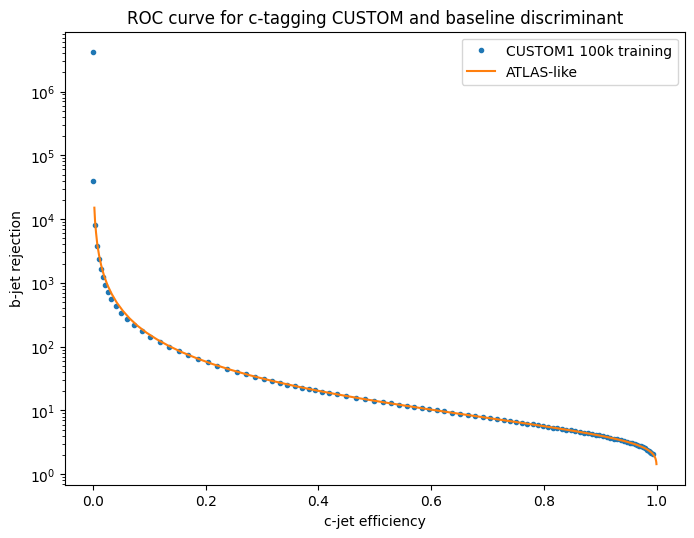

In [53]:
plt.figure(figsize=(8,6), dpi=100)
#plt.plot(c_eff_CUSTOM1_10k, b_rej_CUSTOM1_10k, ".", label = "CUSTOM1 10k training")
#plt.plot(c_eff_CUSTOM1_10k_rw, b_rej_CUSTOM1_10k_rw, ".", label = "CUSTOM1 100k training \n with reweighting")
plt.plot(c_eff_CUSTOM1_100k, b_rej_CUSTOM1_100k, ".", label = "CUSTOM1 100k training")
#plt.plot(c_eff_CUSTOM2_100k, b_rej_CUSTOM2_100k, "-", label = "CUSTOM2 100k training")
#plt.plot(c_eff_CUSTOM3_100k, b_rej_CUSTOM3_100k, ".", label = "CUSTOM3 100k training")
#plt.plot(c_eff_pc, b_rej_pc, label = "pc only")
plt.plot(c_eff_ATLAS, b_rej_ATLAS,  label = "ATLAS-like")
#plt.plot(c_eff_CMS, b_rej_CMS, label = "CMS-like")
plt.yscale("log", base = 10)
plt.xlabel("c-jet efficiency")
plt.ylabel("b-jet rejection")
plt.title("ROC curve for c-tagging CUSTOM and baseline discriminant")
plt.legend()
plt.show()